<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/01_MNIST_TPU_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST on TPU (Tensor Processing Unit)<br>or GPU using tf.Keras and tf.data.Dataset
<table><tr><td><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/keras-tensorflow-tpu300px.png"   width="300" alt="Keras+Tensorflow+Cloud TPU"></td></tr></table>


This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

<h3><a href="https://cloud.google.com/gpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/gpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on GPU or TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

  1. Select a GPU or TPU backend (Runtime > Change runtime type) 
  1. Runtime > Run All <br/>(Watch out: the "Colab-only auth" cell requires user input. <br/>The "Deploy" part at the end requires cloud project and bucket configuration.)

<h3><a href="https://cloud.google.com/ml-engine/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/mlengine-hexagon.png" width="50"></a>  &nbsp;&nbsp;Deploy to AI Platform</h3>
At the bottom of this notebook you can deploy your trained model to AI Platform for a serverless, autoscaled, REST API experience. You will need a Google Cloud project and a GCS (Google Cloud Storage) bucket for this last part.

TPUs are located in Google Cloud, for optimal performance, they read data directly from Google Cloud Storage.

### Imports

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.0.0-dev20190903


In [30]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets.
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.apply(tf.data.experimental.unbatch()).batch(N)
  
  # TF 2.0 change here: since eager mode is the default in TF 2.0, iterating through a tf.data.Dataset just works
  for validation_digits, validation_labels in validation_dataset:
    validation_digits = validation_digits.numpy()
    validation_labels = validation_labels.numpy()
    break
  for training_digits, training_labels in batch_train_ds:
    training_digits = training_digits.numpy()
    training_labels = training_labels.numpy()
    break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

*(you can double-ckick on collapsed cells to view the non-essential code inside)*

### Colab-only auth for this notebook and the TPU

In [31]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

### TPU or GPU detection

In [4]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  # TF 2.0 change here: experimental_connect_to_cluster and initialize_tpu_system are now necessary
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  # TF 2.0 change here: steps_per_run does not exist anymore and is not needed
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['192.168.94.2:8470']
Number of accelerators:  8


### Parameters

In [32]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [33]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

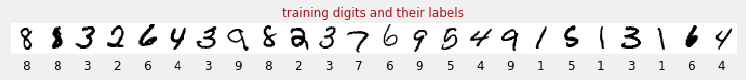

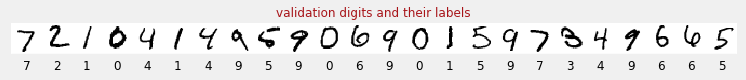

In [34]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [8]:
# This model trains to 99.4% accuracy in 10 epochs (with a batch size of 64)  

def make_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
with strategy.scope():
    model = make_model()

# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

W0905 22:36:16.836138 140213332137728 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/keras/layers/normalization.py:625: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (Reshape)              (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0

### Train and validate the model

In [9]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
# TF 2.0 change here: combined training and evaluation works again on TPU (perf bug in TF 1.14)
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_steps=1,
                    callbacks=[lr_decay])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  117
Train for 117 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
117/117 [==============================] - 9s 79ms/step - loss: 0.1678 - accuracy: 0.9492 - val_loss: 0.4856 - val_accuracy: 0.8415

Epoch 00002: LearningRateScheduler reducing learning rate to 0.006999999999999999.
Epoch 2/10
117/117 [==============================] - 1s 12ms/step - loss: 0.0528 - accuracy: 0.9839 - val_loss: 0.3442 - val_accuracy: 0.8786

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0049.
Epoch 3/10
117/117 [==============================] - 1s 13ms/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0568 - val_accuracy: 0.9841

Epoch 00004: LearningRateScheduler reducing learning rate to 0.003429999999999999.
Epoch 4/10
117/117 [==============================] - 1s 13ms/step - loss: 0.0266 - accuracy: 0.9921 - val_loss: 0.0253 - val_accuracy: 0.9918

Epoch 00005: LearningRateScheduler reducing learning rate

dict_keys(['val_loss', 'accuracy', 'loss', 'lr', 'val_accuracy'])


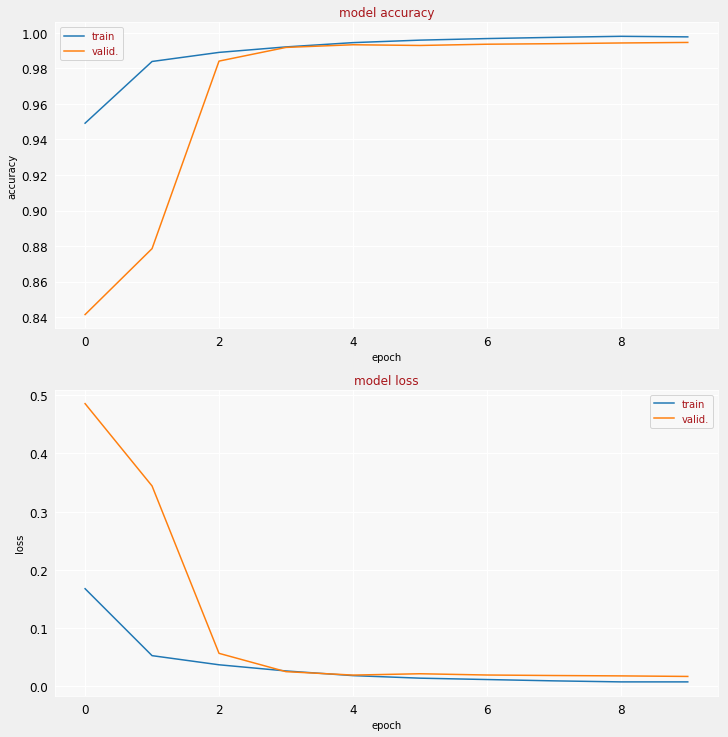

In [10]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Visualize predictions

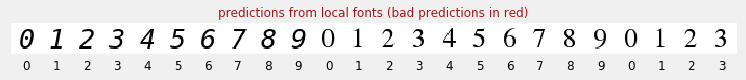

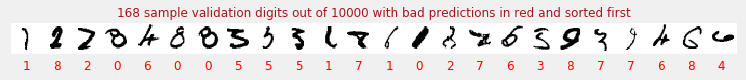

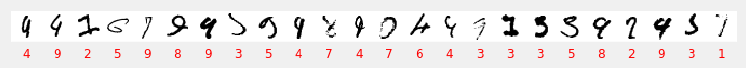

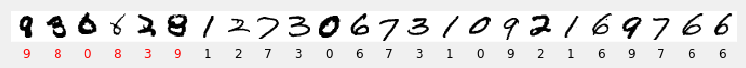

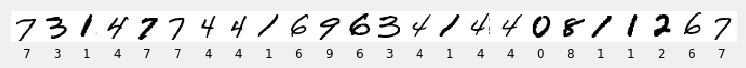

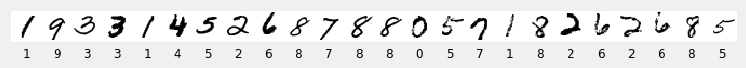

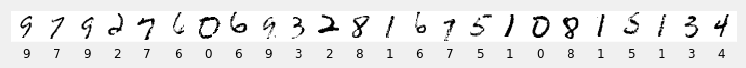

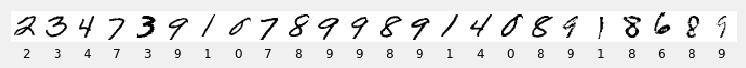

In [11]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to AI Platform model serving

Push your trained model to production on AI Platform for a serverless, autoscaled, REST API experience.

You will need a GCS (Google Cloud Storage) bucket and a GCP project for this.
Models deployed on AI Platform autoscale to zero if not used. There will be no AI Platform charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Configuration

In [12]:
PROJECT = "gcp-tpupods-demo" #@param {type:"string"}
BUCKET = "gs://gcp-tpupods-demo-test"  #@param {type:"string", default:"jddj"}
NEW_MODEL = False #@param {type:"boolean"}
MODEL_NAME = "mnist" #@param {type:"string"}
MODEL_VERSION = "v2" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from AI Platform

In [13]:
# Wrap the model so that we can add a serving function
class ExportModel(tf.keras.Model):
  def __init__(self, model):
    super().__init__(self)
    self.model = model

  # The serving function performig data pre- and post-processing.
  # Pre-processing:  images are received in uint8 format converted
  #                  to float32 before being sent to through the model.
  # Post-processing: the Keras model outputs digit probabilities. We want
  #                  the detected digits. An additional tf.argmax is needed.
  # @tf.function turns the code in this function into a Tensorflow graph that
  # can be exported. This way, the model itself, as well as its pre- and post-
  # processing steps are exported in the SavedModel and deployed in a single step.
  @tf.function(input_signature=[tf.TensorSpec([None, 28*28], dtype=tf.uint8)])
  def my_serve(self, images):
    images = tf.cast(images, tf.float32)/255   # pre-processing
    probabilities = self.model(images, training=False) # prediction from model (training=False is optional)
    classes = tf.argmax(probabilities, axis=-1) # post-processing
    return {'digits': classes}

# TF 2.0 change here: copying the model from TPU to CPU before exporting is no longer required

# create the ExportModel and export it to the Tensorflow standard SavedModel format
serving_model = ExportModel(model)
export_path = os.path.join(BUCKET, 'keras_export', str(time.time()))
# TF 2.0 change here: tf.keras.backend.set_learning_phase(0) no longer needed (was workaround for a TF 1.14 bug)
tf.saved_model.save(serving_model, export_path, signatures={'serving_default': serving_model.my_serve})

# This should work too with TF 2.0 but does not yet...
# serving_model.save(export_path, save_format="tf", signatures={'serving_default': serving_model.my_serve})

print("Model exported to: ", export_path)

W0905 22:38:31.008954 140213332137728 save.py:164] Skipping full serialization of Keras model <__main__.ExportModel object at 0x7f85841bc390>, because its inputs are not defined.
W0905 22:38:34.406867 140213332137728 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1782: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model exported to:  gs://gcp-tpupods-demo-test/keras_export/1567723110.7334921


In [14]:
# saved_model_cli: a useful too for troubleshooting SavedModels (the tool is part of the Tensorflow installation)
!saved_model_cli show --dir {export_path}
!saved_model_cli show --dir {export_path} --tag_set serve
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default
# A note on naming:
# The "serve" tag set (i.e. serving functionality) is the only one exported by tf.saved_model.save
# All the other names are defined by the user in the fllowing lines of code:
#      def myserve(self, images):
#                        ******
#        return {'digits': classes}
#                 ******
#      tf.saved_model.save(..., signatures={'serving_default': serving_model.myserve})
#                                            ***************

The given SavedModel contains the following tag-sets:
serve
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"
The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, 784)
      name: serving_default_images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['digits'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


### Deploy the model
This uses the command-line interface. You can do the same thing through the AI Platform UI at https://console.cloud.google.com/mlengine/models


In [15]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

In [16]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ai-platform versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.14 --python-version=3.5

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/mnist
Creating version (this might take a few minutes)......done.                    


### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [17]:
# prepare digits to send to online prediction endpoint
digits_float32 = np.concatenate((font_digits, validation_digits[:100-N])) # pixel values in [0.0, 1.0] float range
digits_uint8 = np.round(digits_float32*255).astype(np.uint8) # pixel values in [0, 255] int range
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits_uint8:
    # the format for AI Platform online predictions is: one JSON object per line
    data = json.dumps({"images": digit.tolist()})  # "images" because that was the name you gave this parametr in the serving funtion my_serve
    f.write(data+'\n')

['DIGITS', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '1', '2', '3', '7', '2', '1', '0', '4', '1', '4', '9', '5', '9', '0', '6', '9', '0', '1', '5', '9', '7', '3', '4', '9', '6', '6', '5', '4', '0', '7', '4', '0', '1', '3', '1', '3', '4', '7', '2', '7', '1', '2', '1', '1', '7', '4', '2', '3', '5', '1', '2', '4', '4', '6', '3', '5', '5', '6', '0', '4', '1', '9', '5', '7', '8', '9', '3', '7', '4', '6', '4', '3', '0', '7', '0', '2', '9', '1', '7']


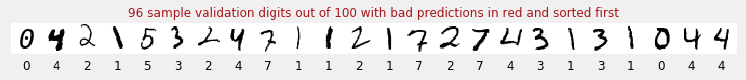

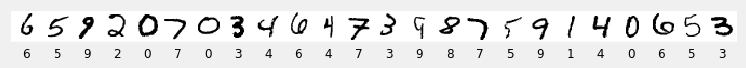

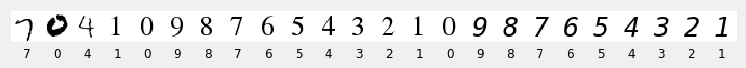

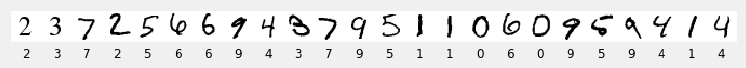

In [18]:
# Request online predictions from deployed model (REST API) using the "gcloud ml-engine" command line.
predictions = !gcloud ai-platform predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

predictions = np.stack([json.loads(p) for p in predictions[1:]]) # first elemet is the name of the output layer: drop it, parse the rest
display_top_unrecognized(digits_float32, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
